In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
from sklearn.metrics import mean_absolute_error as mae
from statsmodels.tsa.stattools import adfuller
from statsforecast.models import ARIMA
import itertools

In [13]:
def load_data_comp_train():
    train = pd.read_csv('../data/train.csv')
    client = pd.read_csv('../data/client.csv')
    electricity_prices = pd.read_csv('../data/electricity_prices.csv')
    forecast_weather = pd.read_csv('../data/forecast_weather.csv')
    gas_prices = pd.read_csv('../data/gas_prices.csv')
    historical_weather = pd.read_csv('../data/historical_weather.csv')

    return (train, client, electricity_prices, forecast_weather,
            gas_prices, historical_weather)


def load_data_comp_test():
    test = pd.read_csv('../data/example_test_files/test.csv')
    client_test = pd.read_csv('../data/example_test_files/client.csv')
    electricity_prices_test = pd.read_csv('../data/example_test_files/electricity_prices.csv')
    forecast_weather_test = pd.read_csv('../data/example_test_files/forecast_weather.csv')
    gas_prices_test = pd.read_csv('../data/example_test_files/gas_prices.csv')
    historical_weather_test = pd.read_csv('../data/historical_weather.csv')

    return (test, client_test, electricity_prices_test, forecast_weather_test,
            gas_prices_test, historical_weather_test)


def conc_raiz_unitaria(adf_result):
    if adf_result[1] > 0.05:
        return 'Hay raíz unitaria (No estacionario)'
    return 'No hay raíz unitaria (Estacionario)'


def guardar_acf_pacf(data, target, key, lags=40, path='imagenes/acf_pacf/'):
    fig, ax = plt.subplots(2,1)
    fig = plot_acf(data[target], lags=lags, ax=ax[0])
    fig = plot_pacf(data[target], lags=lags, ax=ax[1])
    plt.savefig(f'{path}{key}.png')
    plt.title(f'ACF y PACF para {key}')
    plt.show()
    return None


def guardar_decomposition(data, target, key, rows=4000, path='imagenes/decomposition/'):
    dec = seasonal_decompose(data[target][0:rows], model='additive', period=24)
    plt.rc("figure", figsize=(12,6))
    dec.plot(observed=False)
    plt.savefig(f'{path}{key}.png')
    plt.title(f'Decomposición para {key}')
    plt.show()
    return None


def buscar_mejor_modelo(time_serie_train, time_serie_test, pqd, seasonal_pdq, m=24, index=0):
    df_model_tmp = pd.DataFrame(columns=['model', 'ljung_box (p-value)', 'jarque_bera (p-value)', 'MAE'],
                                index=[index])
    for param in pqd:
        for param_seasonal in seasonal_pdq:
            print(f'Probando un ARIMA{param}{param_seasonal}({(m)})')
            model = ARIMA(order=param, seasonal_order=param_seasonal, season_length=m)
            model.fit(time_serie_train.y.values)
            forecast = model.predict(time_serie_test.shape[0])
            error = mae(time_serie_test.y, forecast['mean'])
            
            ljunbox = acorr_ljungbox(model.model_['residuals'], lags=[40])
            jarque_bera_test = jarque_bera(model.model_['residuals'])
            df_model_tmp = pd.concat([df_model_tmp, 
                                      pd.DataFrame({'model': [f'ARIMA{param}{param_seasonal}{(m)}'],
                                                    'ljung_box (p-value)': [f'{np.round(ljunbox.lb_stat.values[0], 4)}({np.round(ljunbox.lb_pvalue.values[0], 4)})'],
                                                    'jarque_bera (p-value)': [f'{np.round(jarque_bera_test[0],4)}({np.round(jarque_bera_test[1],4)})'],
                                                    'MAE': [np.round(error,6)]})])
    best_model = df_model_tmp.loc[df_model_tmp.MAE==np.min(df_model_tmp.MAE)]
    best_model.reset_index(drop=True, inplace=True)
    if best_model.shape[0] > 1:
        best_model = best_model.iloc[0, :]
        
    best_model.index = [index]
    return df_model_tmp, best_model
    

def save_results(data, unique_combinations, cols_to_group = ['county', 'is_business', 'product_type', 'is_consumption'], target='target'):
    df_res = pd.DataFrame(columns=['county', 'is_business', 'product_type', 'is_consumption', 
                                   'model', 'adf_result (p-value)', 'ljung_box (p-value)', 'jarque_bera (p-value)', 'MAE'])
    
    for i in range(unique_combinations.shape[0]):
        print("-----------------------------------------------------------------------------------------------------------------")
        tmp_res = pd.DataFrame(columns=['county', 'is_business', 'product_type', 'is_consumption', 
                                        'model', 'adf_result (p-value)', 'ljung_box (p-value)', 'jarque_bera (p-value)', 'MAE'], 
                               index=[i])
        tmp_res.loc[tmp_res.index == i, "county"] = unique_combinations.iloc[i].county
        tmp_res.loc[tmp_res.index == i, "is_business"] = unique_combinations.iloc[i].is_business
        tmp_res.loc[tmp_res.index == i, "product_type"] = unique_combinations.iloc[i].product_type
        tmp_res.loc[tmp_res.index == i, "is_consumption"] = unique_combinations.iloc[i].is_consumption
        
        key = "".join(f'county: {unique_combinations.iloc[i].county}, '
                      f'is_business: {unique_combinations.iloc[i].is_business}, '
                      f'product_type: {unique_combinations.iloc[i].product_type}, '
                      f'is_consumption: {unique_combinations.iloc[i].is_consumption}')
        
        print(f'Procesando {key}')
        tmp = (data.copy().loc[data[cols_to_group].eq(unique_combinations.iloc[i]).all(axis=1)])
        tmp[target].interpolate(method='linear', inplace=True)
        tmp.reset_index(drop=True, inplace=True)
        
        print(f'Generando ACF y PACF para {key}\n')
        guardar_acf_pacf(tmp, target, key)
        print(f'Guardado exitosamente en /imagenes/acf_pacf\n')
        
        print(f'Generando Decomposición para {key}\n')
        guardar_decomposition(tmp, target, key)
        print(f'Guardado exitosamente en /imagenes/decomposition\n')
        
        print(f'Test de ADF para {key}\n')
        adf_result = adfuller(tmp[target])
        print(f'ADF Statistic: {np.round(adf_result[0],4)}, p-value: {np.round(adf_result[1],4)}, conclusión: {conc_raiz_unitaria(adf_result)}')
        tmp_res.loc[tmp_res.index == i  ,'adf_result'] = f'{np.round(adf_result[0],4)}({np.round(adf_result[1],4)})'
 
        print(f'Entrenando modelo ARIMA para {key}\n')
        print(f'Generando combinaciones de hiperparámetros para {key}\n')
        if adf_result[1] > 0.05:
            print('Se aplica diferenciación ya que la serie no es estacionaria\n')
            d = range(1, 2)
            p = range(1, 3)
            q = range(1, 3)
            
        else:
            print('No se aplica diferenciación ya que la serie es estacionaria\n')
            d = range(0, 1)
            p = range(1, 3)
            q = range(1, 3)
        
        D = range(0, 2)
        P = range(1, 3)
        Q = range(0, 2)
        pdq = list(itertools.product(p, d, q))
        seasonal_pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(P, D, Q))]
        seasonal_length = 24

        print(f'El número de modelos a probar es {len(pdq)*len(seasonal_pdq)}')
        
        train_size = int(0.8 * tmp.shape[0])
        train_data_ext, test_data_ext = tmp[:train_size], tmp[train_size:]
        
        ts_exp_tr= train_data_ext.copy().rename(columns={'datetime': 'ds', 'target': 'y'})
        ts_exp_te = test_data_ext.copy().rename(columns={'datetime': 'ds', 'target': 'y'})
        
        # Buscando mejor modelo
        print(f'Buscando mejor modelo para {key}\n')
        df_model_tmp, best_model = buscar_mejor_modelo(ts_exp_tr, ts_exp_te, pdq, seasonal_pdq, seasonal_length, index=i)
        
        tmp_res.loc[tmp_res.index == i, 'model'] = best_model.model
        tmp_res.loc[tmp_res.index == i, 'ljung_box (p-value)'] = best_model['ljung_box (p-value)']
        tmp_res.loc[tmp_res.index == i, 'jarque_bera (p-value)'] = best_model['jarque_bera (p-value)']
        tmp_res.loc[tmp_res.index == i, 'MAE'] = best_model.MAE
        
        print(f'Los modelos probados para {key} son: \n{df_model_tmp}')
        
        print(f'El mejor modelo para {key} es: \n{best_model}')  
        df_res = pd.concat([df_res, tmp_res])
        
    return df_res

In [4]:
train, client, electricity_prices, forecast_weather, gas_prices, historical_weather = load_data_comp_train()
test, client_test, electricity_prices_test, forecast_weather_test, gas_prices_test, historical_weather_test = load_data_comp_test()

## Introducción a los modelos de series temporales

### Modelos autorregresivos

En los modelos autorregresivos son un tipo de modelo de series temporales que asume que los valores pasados de la serie temporal tienen un efecto en los valores actuales. En otras palabras, el valor actual de la serie temporal depende de los valores pasados de la serie temporal. La idea detrás de los modelos autorregresivos es que la serie temporal se puede modelar como una combinación lineal de sus valores pasados. La ecuación de un modelo autorregresivo de orden p (AR(p)) es la siguiente: 
$$ y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t-p} + \epsilon_t $$

Donde:
- $y_t$ es el valor actual de la serie temporal
- $c$ es una constante
- $\phi_1, \phi_2, ..., \phi_p$ son los coeficientes de los valores pasados de la serie temporal
- $\epsilon_t$ es el término de error en el tiempo t
- p es el orden del modelo
- $y_{t-1}, y_{t-2}, ..., y_{t-p}$ son los valores pasados de la serie temporal

El modelo AR(p) se puede escribir de forma más compacta como:
$$ y_t = c + \sum_{i=1}^{p} \phi_i y_{t-i} + \epsilon_t $$

El modelo MA(q) es un modelo de media móvil que asume que el valor actual de la serie temporal depende de los errores pasados de la serie temporal. La ecuación de un modelo de media móvil de orden q (MA(q)) es la siguiente:
$$ y_t = c + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q} + \epsilon_t $$

Donde:
- $y_t$ es el valor actual de la serie temporal
- $c$ es una constante
- $\theta_1, \theta_2, ..., \theta_q$ son los coeficientes de los errores pasados de la serie temporal
- $\epsilon_t$ es el término de error en el tiempo t
- q es el orden del modelo
- $\epsilon_{t-1}, \epsilon_{t-2}, ..., \epsilon_{t-q}$ son los errores pasados de la serie temporal
- El modelo MA(q) se puede escribir de forma más compacta como: $y_t = c + \sum_{i=1}^{q} \theta_i \epsilon_{t-i} + \epsilon_t $
- El modelo AR(p) y el modelo MA(q) se pueden combinar en un modelo ARMA(p, q) que incluye términos autorregresivos y de media móvil. El modelo ARMA(p, q) se puede escribir de la siguiente manera: $y_t = c + \sum_{i=1}^{p} \phi_i y_{t-i} + \sum_{i=1}^{q} \theta_i \epsilon_{t-i} + \epsilon_t $

El modelo ARMA(p,q) se puede extender a un modelo ARIMA(p, d, q) que incluye un término de diferenciación d. El modelo ARIMA(p, d, q) se puede escribir de la siguiente manera:

$$ y_t = c + \sum_{i=1}^{p} \phi_i y_{t-i} + \sum_{i=1}^{q} \theta_i \epsilon_{t-i} + \epsilon_t $$

Donde:
- $y_t$ es el valor actual de la serie temporal
- $c$ es una constante
- $\phi_1, \phi_2, ..., \phi_p$ son los coeficientes de los valores pasados de la serie temporal
- $\theta_1, \theta_2, ..., \theta_q$ son los coeficientes de los errores pasados de la serie temporal
- $\epsilon_t$ es el término de error en el tiempo t
- p es el orden del modelo autorregresivo
- d es el orden de diferenciación
- q es el orden del modelo de media móvil
- $y_{t-1}, y_{t-2}, ..., y_{t-p}$ son los valores pasados de la serie temporal

El modelo ARIMA(p, d, q) se puede extender a un modelo SARIMA(p, d, q)(P, D, Q)s que incluye un término de estacionalidad s. El modelo SARIMA(p, d, q)(P, D, Q)s se puede escribir de la siguiente manera:

$$ y_t = c + \sum_{i=1}^{p} \phi_i y_{t-i} + \sum_{i=1}^{q} \theta_i \epsilon_{t-i} + \sum_{i=1}^{P} \Phi_i y_{t-i} + \sum_{i=1}^{Q} \Theta_i \epsilon_{t-i} + \epsilon_t $$

Donde:

- $y_t$ es el valor actual de la serie temporal
- $c$ es una constante
- $\phi_1, \phi_2, ..., \phi_p$ son los coeficientes de los valores pasados de la serie temporal
- $\theta_1, \theta_2, ..., \theta_q$ son los coeficientes de los errores pasados de la serie temporal
- $\Phi_1, \Phi_2, ..., \Phi_P$ son los coeficientes de los valores pasados de la serie temporal con estacionalidad
- $\Theta_1, \Theta_2, ..., \Theta_Q$ son los coeficientes de los errores pasados de la serie temporal con estacionalidad
- $\epsilon_t$ es el término de error en el tiempo t
- p es el orden del modelo autorregresivo
- d es el orden de diferenciación
- q es el orden del modelo de media móvil
- P es el orden del modelo autorregresivo con estacionalidad
- D es el orden de diferenciación con estacionalidad
- Q es el orden del modelo de media móvil con estacionalidad
- s es la longitud de la estacionalidad
- $y_{t-1}, y_{t-2}, ..., y_{t-p}$ son los valores pasados de la serie temporal

En resumen, los modelos autorregresivos son un tipo de modelo de series temporales que asume que los valores pasados de la serie temporal tienen un efecto en los valores actuales. Los modelos autorregresivos se pueden extender a modelos ARIMA y SARIMA que incluyen términos de diferenciación y estacionalidad. Los modelos autorregresivos son útiles para modelar series temporales con patrones de dependencia temporal.

# Autorregresive models (Para la capital)

In [5]:
# Realizamos el análisis para los segmentos siempre activos
activos = ['31', '51', '45', '8', '15', '35', '56', '20', '60', '50', '32', '6', '18', '55', '57', '4', '54', '42', '28', '33', '14', '1', '34', '39', '48', '3', '53', '29', '37', '16', '43', '5', '46', '58', '23', '24', '10', '7', '2', '36', '49', '27', '12', '30', '59', '19', '22', '52', '0', '11', '25', '9', '13', '38', '17', '40']

In [6]:
# Filtramos la capital
# Para cada county, is_business, product_type, is_consumption, datetime se hará un modelo de ts pata la variable target
cols_to_model = ['county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'target']
cols_to_group = ['county', 'is_business', 'product_type', 'is_consumption']
data_model_capital = (train.copy().loc[(train.prediction_unit_id.astype(str).isin(activos)) & (train.county == 0)][cols_to_model])

In [7]:
unique_combinations = data_model_capital[cols_to_group].drop_duplicates()

## Resultados

Procesando county: 0, is_business: 0, product_type: 1, is_consumption: 0
Generando ACF y PACF para county: 0, is_business: 0, product_type: 1, is_consumption: 0



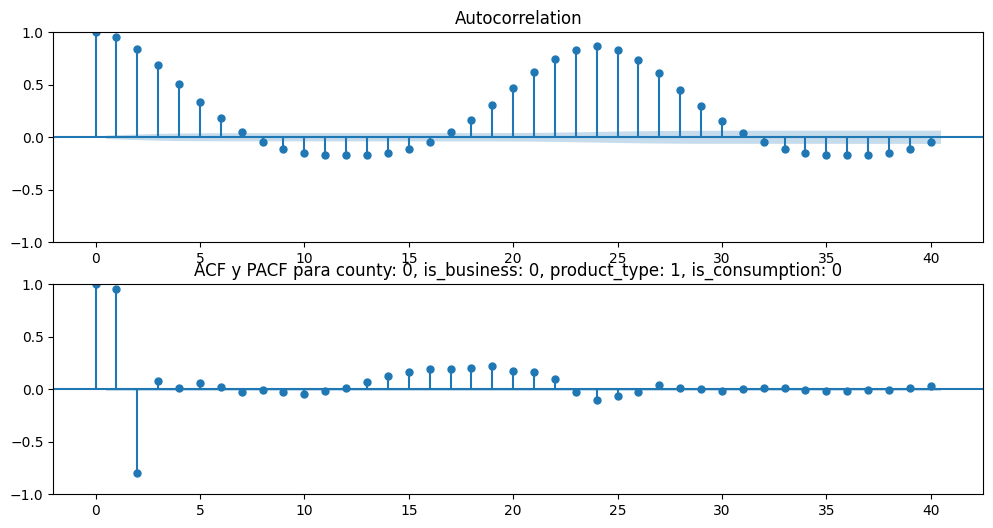

Guardado exitosamente en /imagenes/acf_pacf

Generando Decomposición para county: 0, is_business: 0, product_type: 1, is_consumption: 0



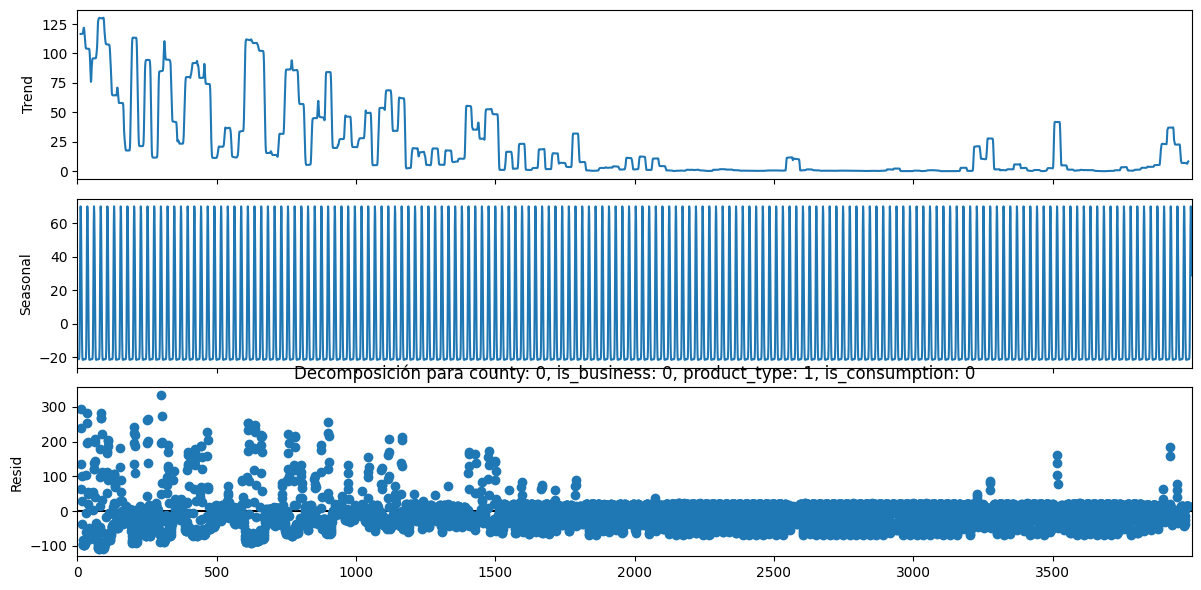

Guardado exitosamente en /imagenes/decomposition

Test de ADF para county: 0, is_business: 0, product_type: 1, is_consumption: 0

ADF Statistic: -4.3183, p-value: 0.0004, conclusión: No hay raíz unitaria (Estacionario)
Entrenando modelo ARIMA para county: 0, is_business: 0, product_type: 1, is_consumption: 0

Generando combinaciones de hiperparámetros para county: 0, is_business: 0, product_type: 1, is_consumption: 0

No se aplica diferenciación ya que la serie es estacionaria

El número de modelos a probar es 32
Buscando mejor modelo para county: 0, is_business: 0, product_type: 1, is_consumption: 0

Probando un ARIMA(1, 0, 1)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 1)(24)
Probando un ARIMA(1, 0, 2)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 2)(1, 0

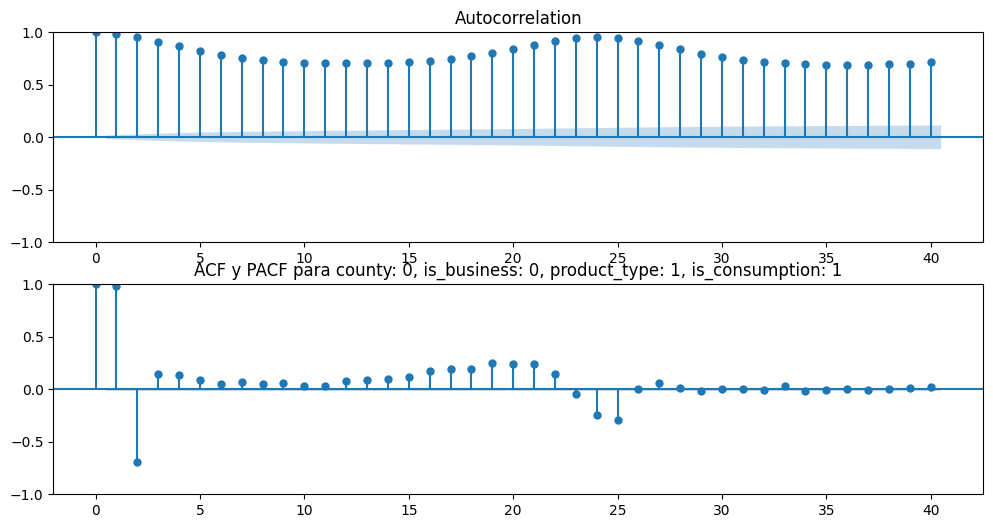

Guardado exitosamente en /imagenes/acf_pacf

Generando Decomposición para county: 0, is_business: 0, product_type: 1, is_consumption: 1



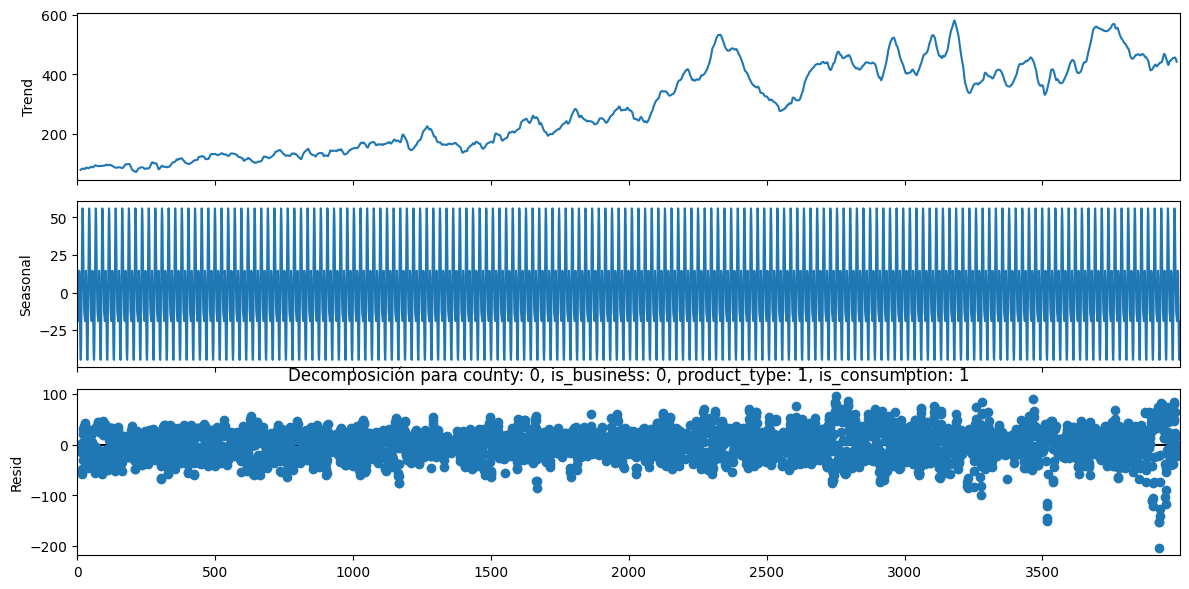

Guardado exitosamente en /imagenes/decomposition

Test de ADF para county: 0, is_business: 0, product_type: 1, is_consumption: 1

ADF Statistic: -2.4731, p-value: 0.1222, conclusión: Hay raíz unitaria (No estacionario)
Entrenando modelo ARIMA para county: 0, is_business: 0, product_type: 1, is_consumption: 1

Generando combinaciones de hiperparámetros para county: 0, is_business: 0, product_type: 1, is_consumption: 1

Se aplica diferenciación ya que la serie no es estacionaria

El número de modelos a probar es 32
Buscando mejor modelo para county: 0, is_business: 0, product_type: 1, is_consumption: 1

Probando un ARIMA(1, 1, 1)(1, 0, 0)(24)
Probando un ARIMA(1, 1, 1)(1, 0, 1)(24)
Probando un ARIMA(1, 1, 1)(1, 1, 0)(24)
Probando un ARIMA(1, 1, 1)(1, 1, 1)(24)
Probando un ARIMA(1, 1, 1)(2, 0, 0)(24)
Probando un ARIMA(1, 1, 1)(2, 0, 1)(24)
Probando un ARIMA(1, 1, 1)(2, 1, 0)(24)
Probando un ARIMA(1, 1, 1)(2, 1, 1)(24)
Probando un ARIMA(1, 1, 2)(1, 0, 0)(24)
Probando un ARIMA(1, 1, 2)(1, 0

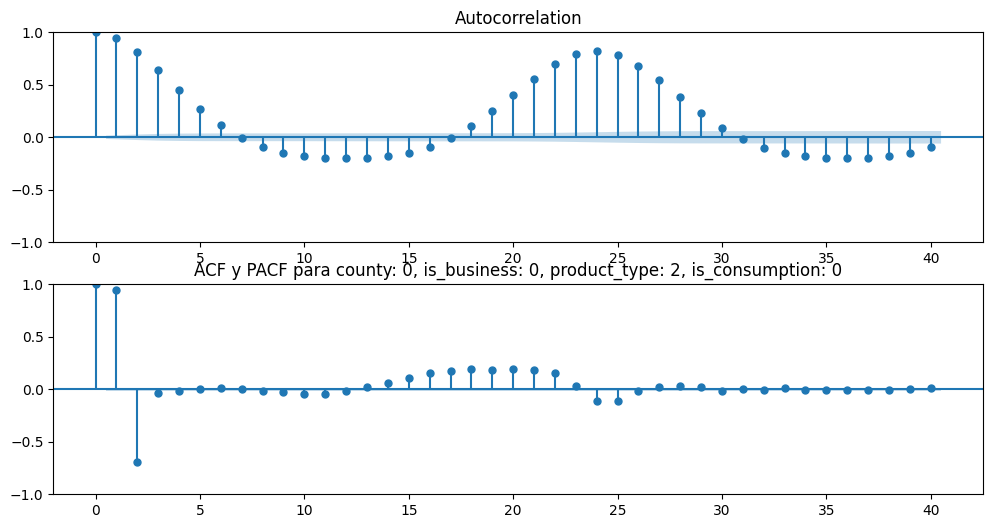

Guardado exitosamente en /imagenes/acf_pacf

Generando Decomposición para county: 0, is_business: 0, product_type: 2, is_consumption: 0



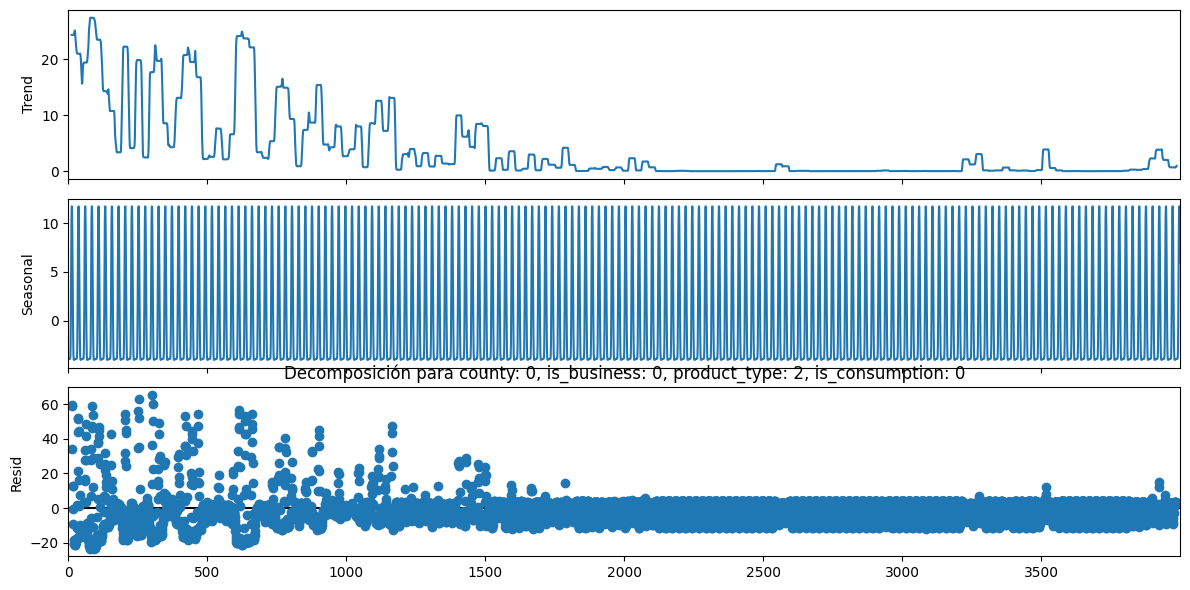

Guardado exitosamente en /imagenes/decomposition

Test de ADF para county: 0, is_business: 0, product_type: 2, is_consumption: 0

ADF Statistic: -6.2698, p-value: 0.0, conclusión: No hay raíz unitaria (Estacionario)
Entrenando modelo ARIMA para county: 0, is_business: 0, product_type: 2, is_consumption: 0

Generando combinaciones de hiperparámetros para county: 0, is_business: 0, product_type: 2, is_consumption: 0

No se aplica diferenciación ya que la serie es estacionaria

El número de modelos a probar es 32
Buscando mejor modelo para county: 0, is_business: 0, product_type: 2, is_consumption: 0

Probando un ARIMA(1, 0, 1)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 1)(24)
Probando un ARIMA(1, 0, 2)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 2)(1, 0, 1

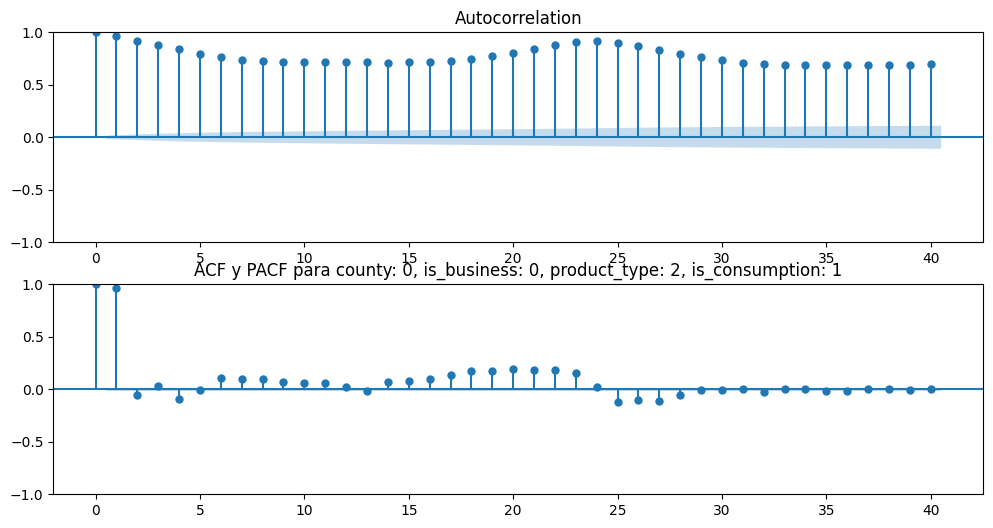

Guardado exitosamente en /imagenes/acf_pacf

Generando Decomposición para county: 0, is_business: 0, product_type: 2, is_consumption: 1



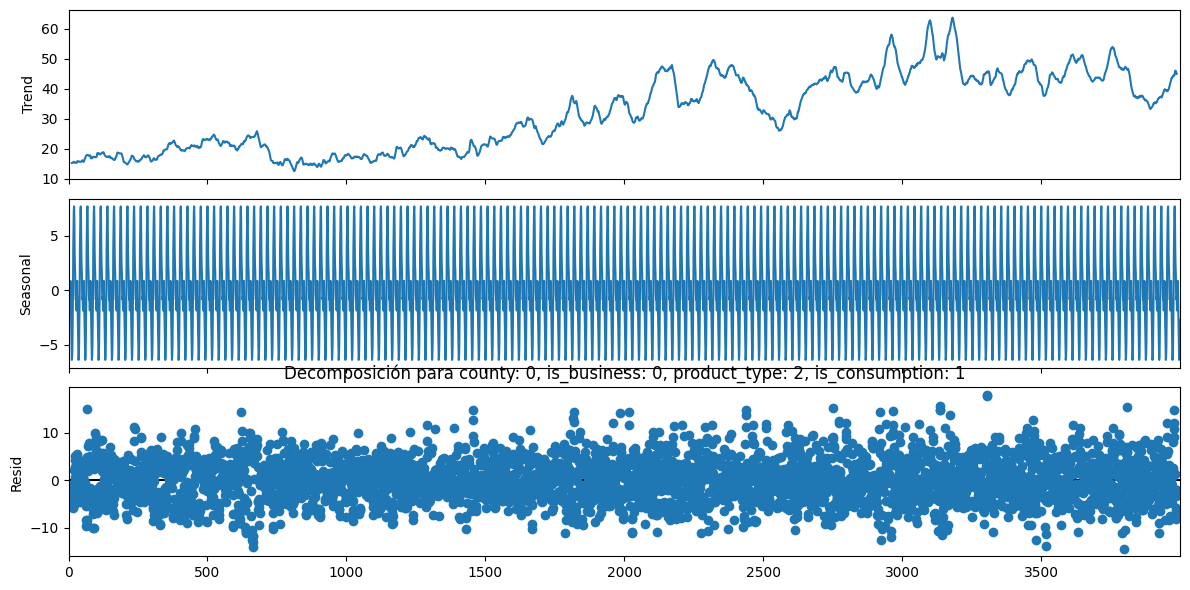

Guardado exitosamente en /imagenes/decomposition

Test de ADF para county: 0, is_business: 0, product_type: 2, is_consumption: 1

ADF Statistic: -3.0414, p-value: 0.0312, conclusión: No hay raíz unitaria (Estacionario)
Entrenando modelo ARIMA para county: 0, is_business: 0, product_type: 2, is_consumption: 1

Generando combinaciones de hiperparámetros para county: 0, is_business: 0, product_type: 2, is_consumption: 1

No se aplica diferenciación ya que la serie es estacionaria

El número de modelos a probar es 32
Buscando mejor modelo para county: 0, is_business: 0, product_type: 2, is_consumption: 1

Probando un ARIMA(1, 0, 1)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 1)(24)
Probando un ARIMA(1, 0, 2)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 2)(1, 0

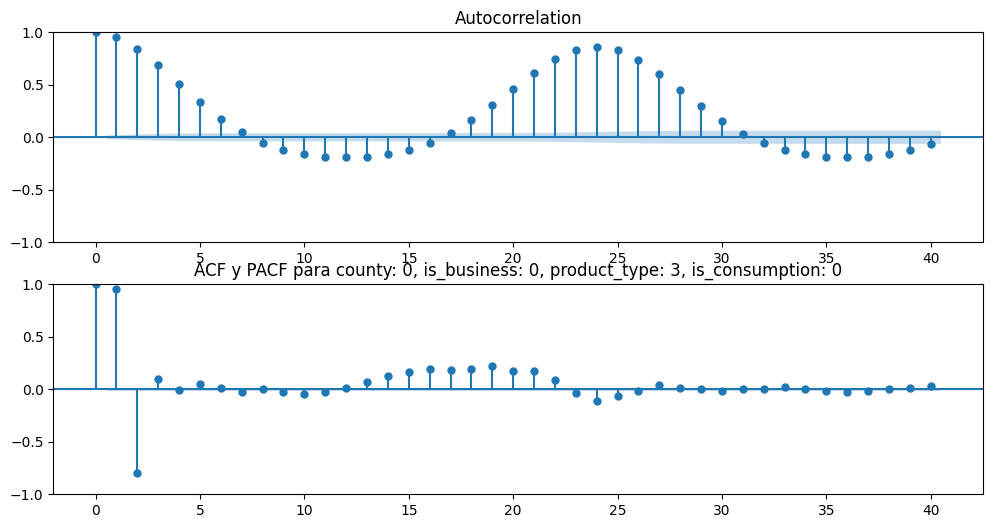

Guardado exitosamente en /imagenes/acf_pacf

Generando Decomposición para county: 0, is_business: 0, product_type: 3, is_consumption: 0



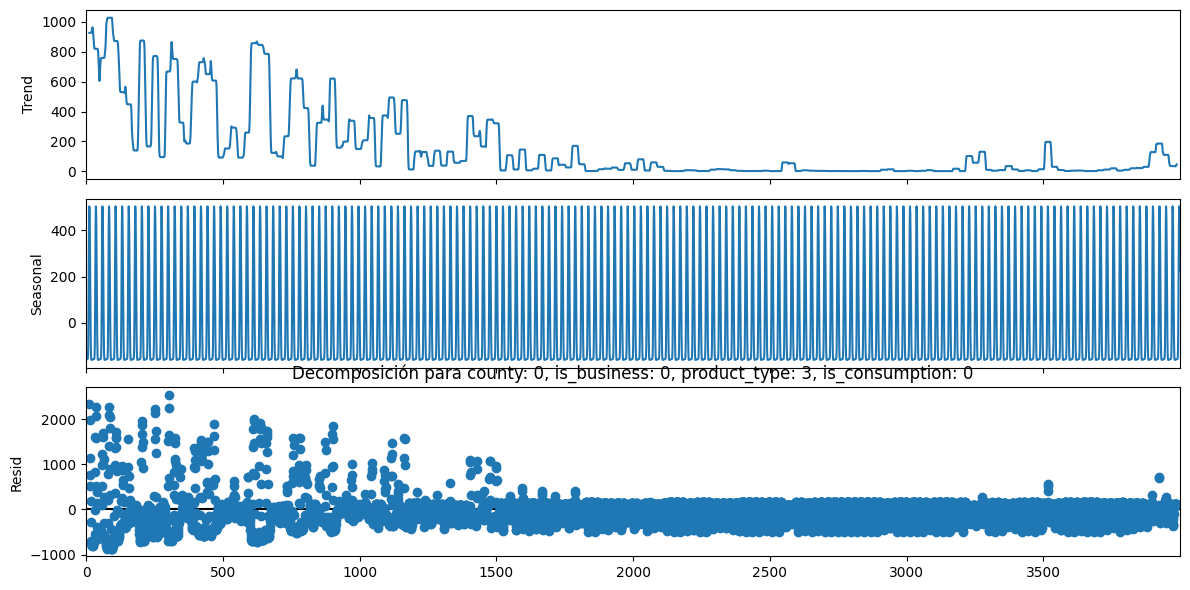

Guardado exitosamente en /imagenes/decomposition

Test de ADF para county: 0, is_business: 0, product_type: 3, is_consumption: 0

ADF Statistic: -4.4789, p-value: 0.0002, conclusión: No hay raíz unitaria (Estacionario)
Entrenando modelo ARIMA para county: 0, is_business: 0, product_type: 3, is_consumption: 0

Generando combinaciones de hiperparámetros para county: 0, is_business: 0, product_type: 3, is_consumption: 0

No se aplica diferenciación ya que la serie es estacionaria

El número de modelos a probar es 32
Buscando mejor modelo para county: 0, is_business: 0, product_type: 3, is_consumption: 0

Probando un ARIMA(1, 0, 1)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 1)(24)
Probando un ARIMA(1, 0, 2)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 2)(1, 0

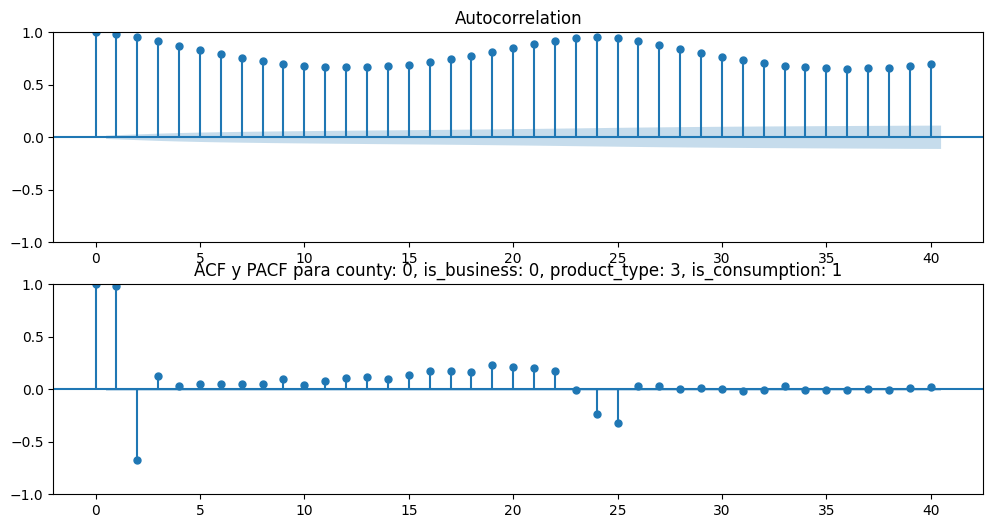

Guardado exitosamente en /imagenes/acf_pacf

Generando Decomposición para county: 0, is_business: 0, product_type: 3, is_consumption: 1



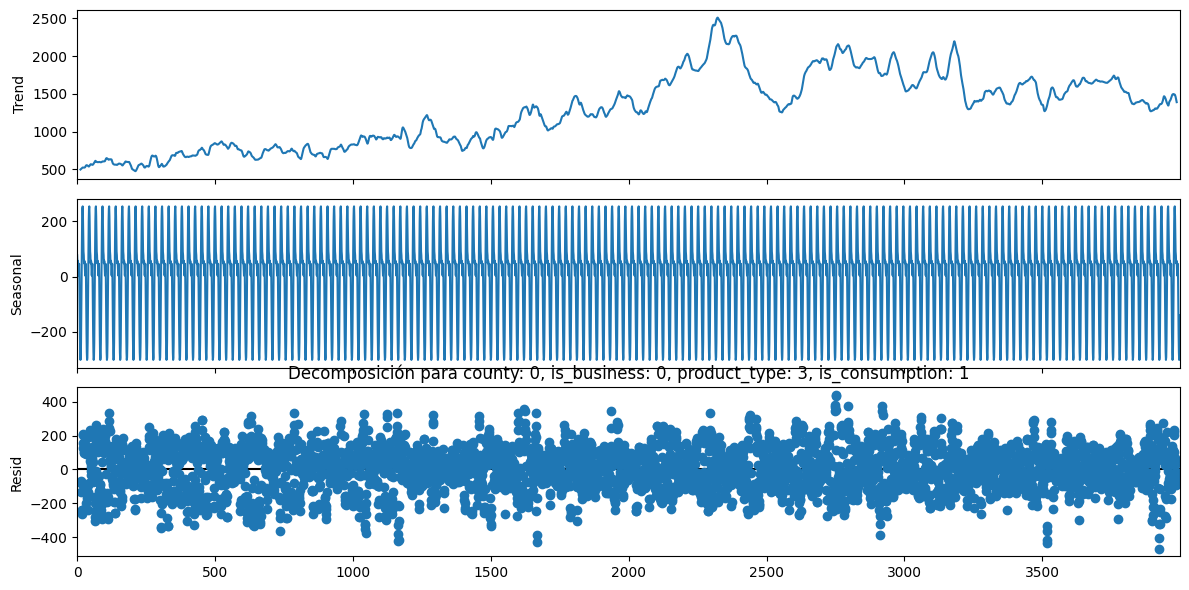

Guardado exitosamente en /imagenes/decomposition

Test de ADF para county: 0, is_business: 0, product_type: 3, is_consumption: 1

ADF Statistic: -2.593, p-value: 0.0944, conclusión: Hay raíz unitaria (No estacionario)
Entrenando modelo ARIMA para county: 0, is_business: 0, product_type: 3, is_consumption: 1

Generando combinaciones de hiperparámetros para county: 0, is_business: 0, product_type: 3, is_consumption: 1

Se aplica diferenciación ya que la serie no es estacionaria

El número de modelos a probar es 32
Buscando mejor modelo para county: 0, is_business: 0, product_type: 3, is_consumption: 1

Probando un ARIMA(1, 1, 1)(1, 0, 0)(24)
Probando un ARIMA(1, 1, 1)(1, 0, 1)(24)
Probando un ARIMA(1, 1, 1)(1, 1, 0)(24)
Probando un ARIMA(1, 1, 1)(1, 1, 1)(24)
Probando un ARIMA(1, 1, 1)(2, 0, 0)(24)
Probando un ARIMA(1, 1, 1)(2, 0, 1)(24)
Probando un ARIMA(1, 1, 1)(2, 1, 0)(24)
Probando un ARIMA(1, 1, 1)(2, 1, 1)(24)
Probando un ARIMA(1, 1, 2)(1, 0, 0)(24)
Probando un ARIMA(1, 1, 2)(1, 0,

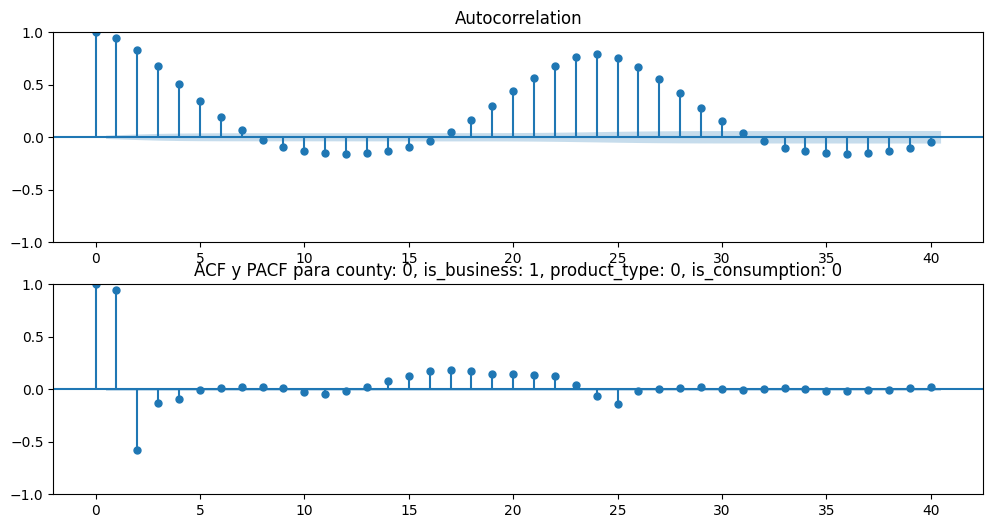

Guardado exitosamente en /imagenes/acf_pacf

Generando Decomposición para county: 0, is_business: 1, product_type: 0, is_consumption: 0



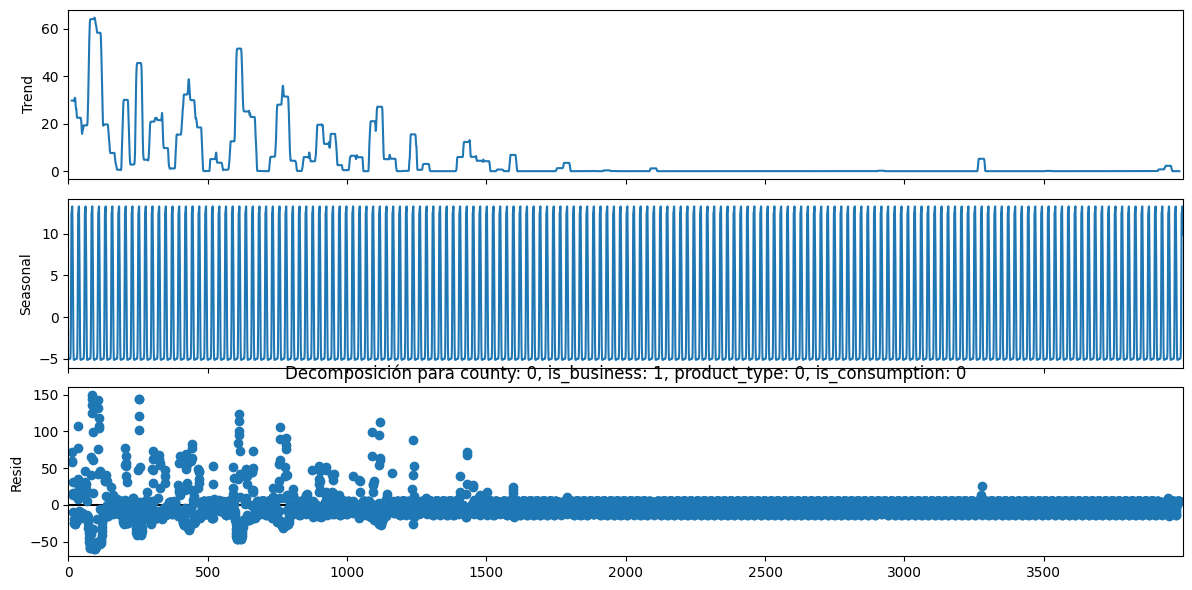

Guardado exitosamente en /imagenes/decomposition

Test de ADF para county: 0, is_business: 1, product_type: 0, is_consumption: 0

ADF Statistic: -6.8639, p-value: 0.0, conclusión: No hay raíz unitaria (Estacionario)
Entrenando modelo ARIMA para county: 0, is_business: 1, product_type: 0, is_consumption: 0

Generando combinaciones de hiperparámetros para county: 0, is_business: 1, product_type: 0, is_consumption: 0

No se aplica diferenciación ya que la serie es estacionaria

El número de modelos a probar es 32
Buscando mejor modelo para county: 0, is_business: 1, product_type: 0, is_consumption: 0

Probando un ARIMA(1, 0, 1)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 1)(24)
Probando un ARIMA(1, 0, 2)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 2)(1, 0, 1

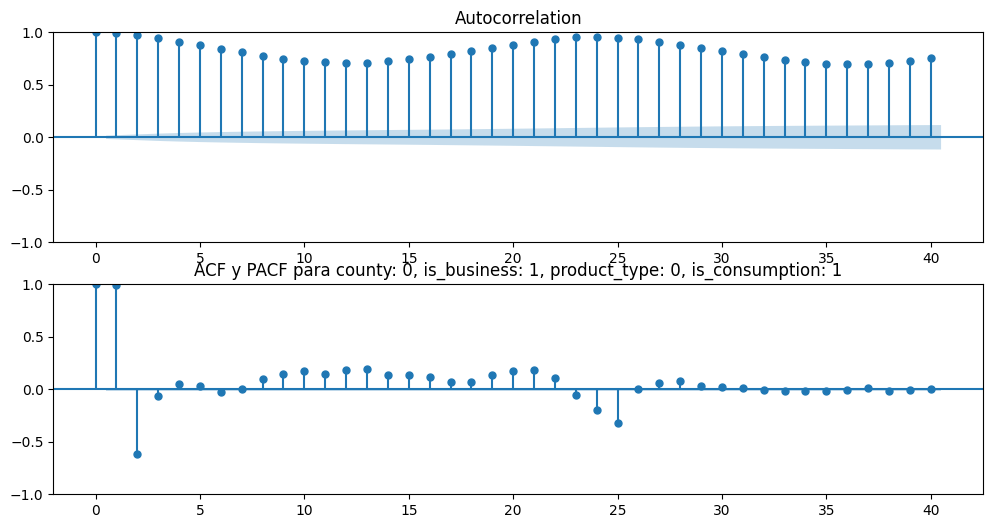

Guardado exitosamente en /imagenes/acf_pacf

Generando Decomposición para county: 0, is_business: 1, product_type: 0, is_consumption: 1



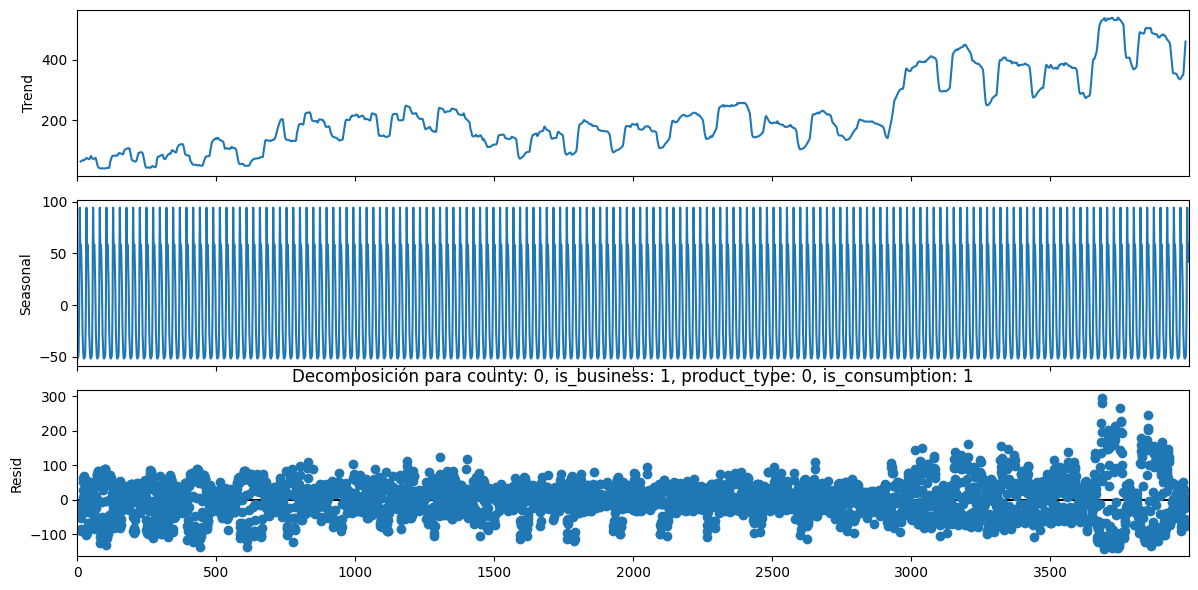

Guardado exitosamente en /imagenes/decomposition

Test de ADF para county: 0, is_business: 1, product_type: 0, is_consumption: 1

ADF Statistic: -3.0124, p-value: 0.0338, conclusión: No hay raíz unitaria (Estacionario)
Entrenando modelo ARIMA para county: 0, is_business: 1, product_type: 0, is_consumption: 1

Generando combinaciones de hiperparámetros para county: 0, is_business: 1, product_type: 0, is_consumption: 1

No se aplica diferenciación ya que la serie es estacionaria

El número de modelos a probar es 32
Buscando mejor modelo para county: 0, is_business: 1, product_type: 0, is_consumption: 1

Probando un ARIMA(1, 0, 1)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 1)(24)
Probando un ARIMA(1, 0, 2)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 2)(1, 0

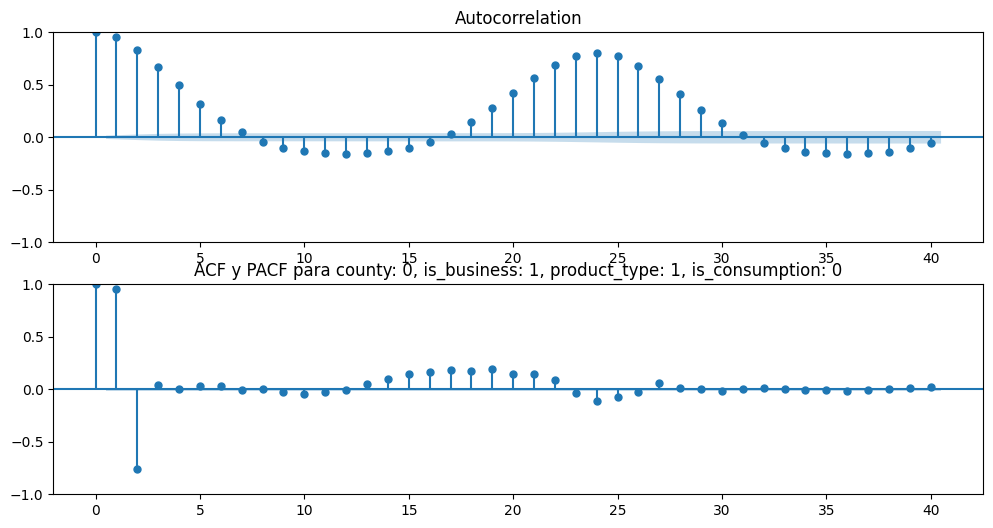

Guardado exitosamente en /imagenes/acf_pacf

Generando Decomposición para county: 0, is_business: 1, product_type: 1, is_consumption: 0



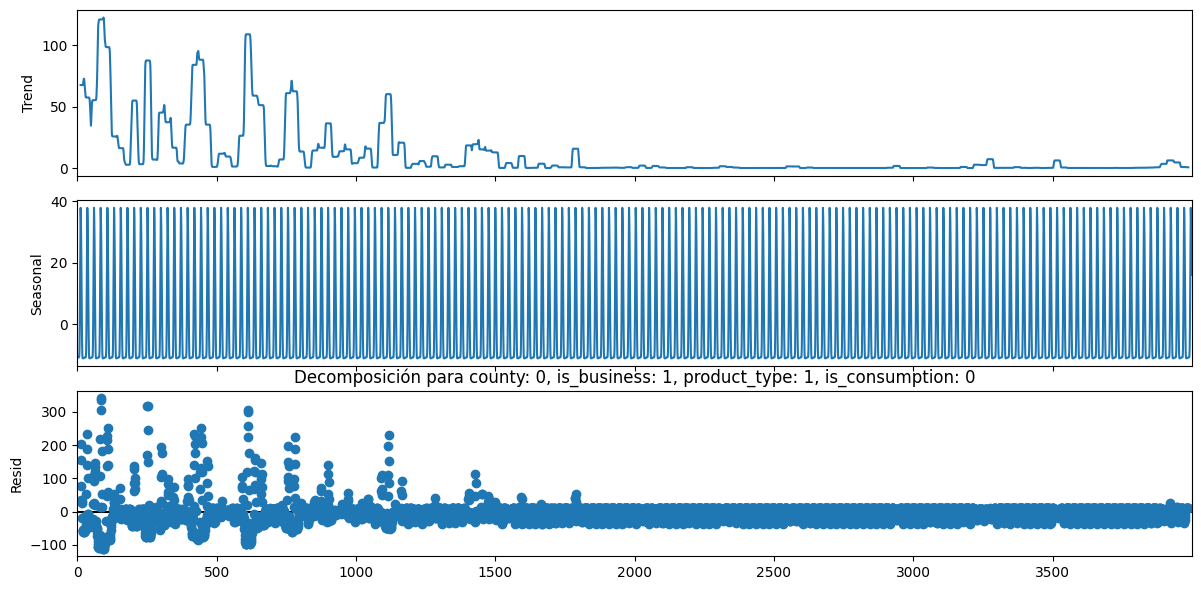

Guardado exitosamente en /imagenes/decomposition

Test de ADF para county: 0, is_business: 1, product_type: 1, is_consumption: 0

ADF Statistic: -6.4028, p-value: 0.0, conclusión: No hay raíz unitaria (Estacionario)
Entrenando modelo ARIMA para county: 0, is_business: 1, product_type: 1, is_consumption: 0

Generando combinaciones de hiperparámetros para county: 0, is_business: 1, product_type: 1, is_consumption: 0

No se aplica diferenciación ya que la serie es estacionaria

El número de modelos a probar es 32
Buscando mejor modelo para county: 0, is_business: 1, product_type: 1, is_consumption: 0

Probando un ARIMA(1, 0, 1)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 1)(24)
Probando un ARIMA(1, 0, 2)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 2)(1, 0, 1

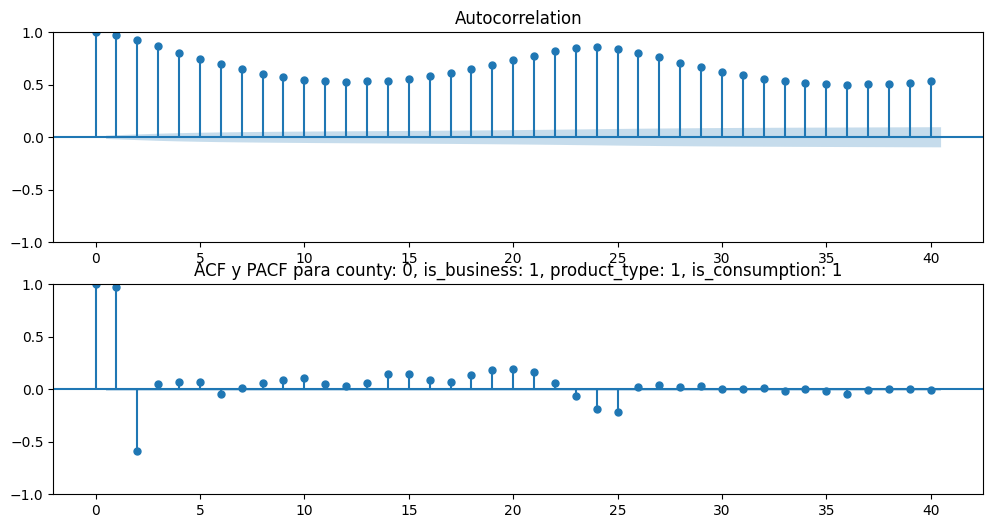

Guardado exitosamente en /imagenes/acf_pacf

Generando Decomposición para county: 0, is_business: 1, product_type: 1, is_consumption: 1



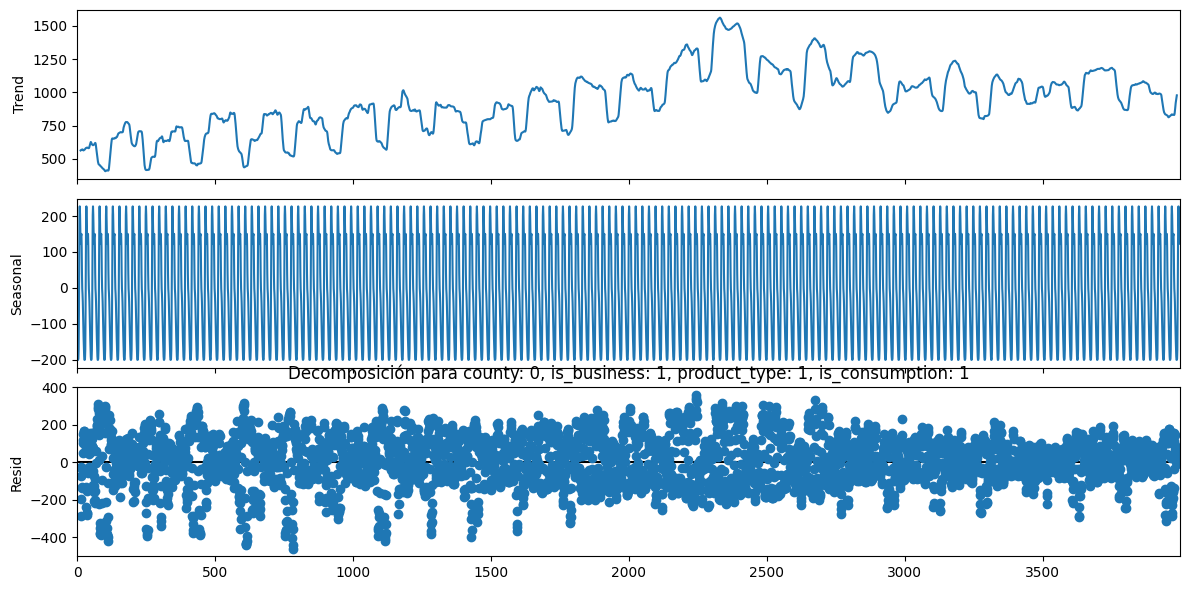

Guardado exitosamente en /imagenes/decomposition

Test de ADF para county: 0, is_business: 1, product_type: 1, is_consumption: 1

ADF Statistic: -5.3525, p-value: 0.0, conclusión: No hay raíz unitaria (Estacionario)
Entrenando modelo ARIMA para county: 0, is_business: 1, product_type: 1, is_consumption: 1

Generando combinaciones de hiperparámetros para county: 0, is_business: 1, product_type: 1, is_consumption: 1

No se aplica diferenciación ya que la serie es estacionaria

El número de modelos a probar es 32
Buscando mejor modelo para county: 0, is_business: 1, product_type: 1, is_consumption: 1

Probando un ARIMA(1, 0, 1)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 1)(24)
Probando un ARIMA(1, 0, 2)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 2)(1, 0, 1

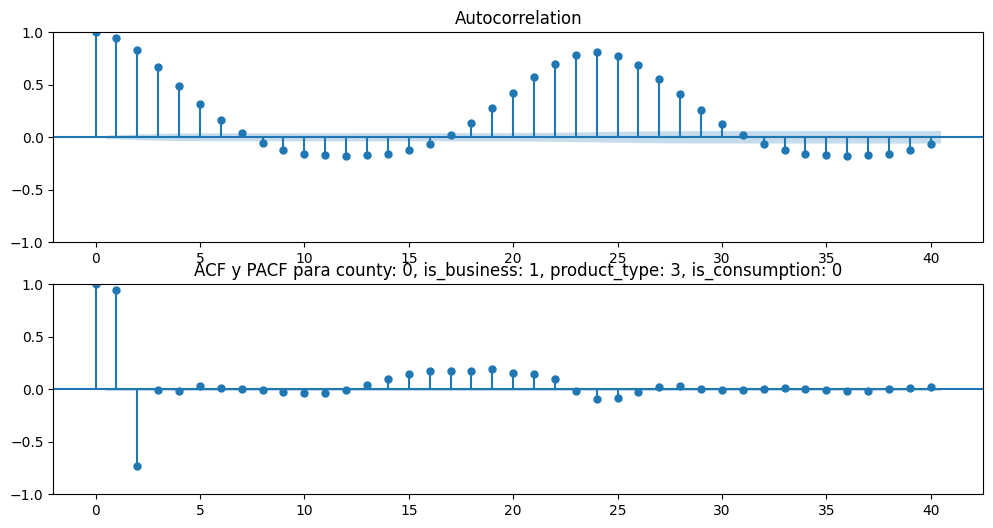

Guardado exitosamente en /imagenes/acf_pacf

Generando Decomposición para county: 0, is_business: 1, product_type: 3, is_consumption: 0



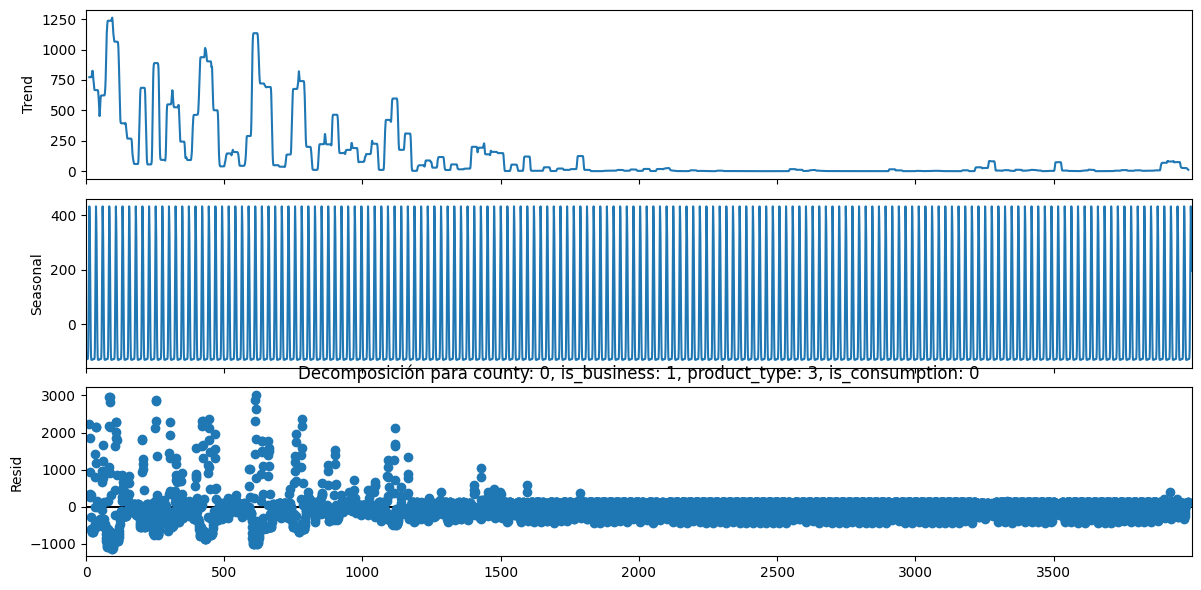

Guardado exitosamente en /imagenes/decomposition

Test de ADF para county: 0, is_business: 1, product_type: 3, is_consumption: 0

ADF Statistic: -6.2694, p-value: 0.0, conclusión: No hay raíz unitaria (Estacionario)
Entrenando modelo ARIMA para county: 0, is_business: 1, product_type: 3, is_consumption: 0

Generando combinaciones de hiperparámetros para county: 0, is_business: 1, product_type: 3, is_consumption: 0

No se aplica diferenciación ya que la serie es estacionaria

El número de modelos a probar es 32
Buscando mejor modelo para county: 0, is_business: 1, product_type: 3, is_consumption: 0

Probando un ARIMA(1, 0, 1)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 1)(24)
Probando un ARIMA(1, 0, 2)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 2)(1, 0, 1

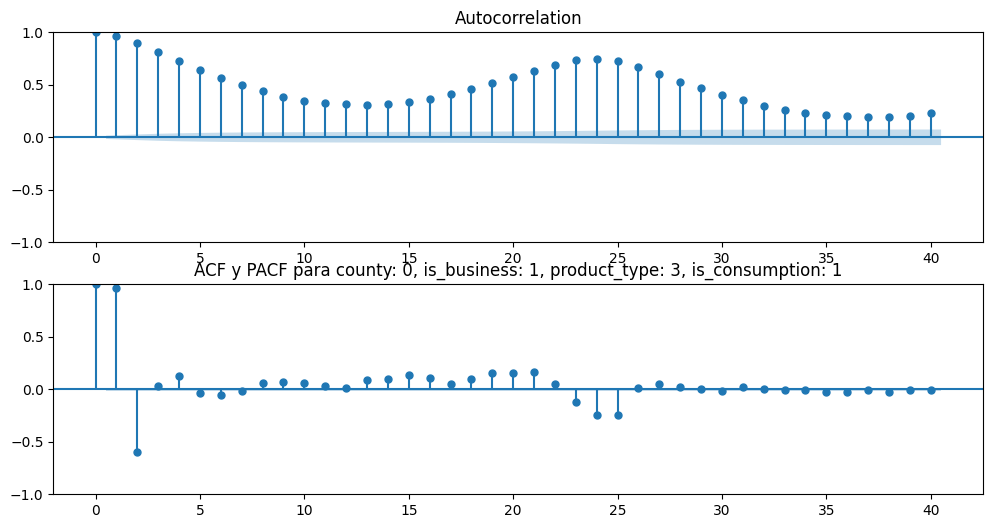

Guardado exitosamente en /imagenes/acf_pacf

Generando Decomposición para county: 0, is_business: 1, product_type: 3, is_consumption: 1



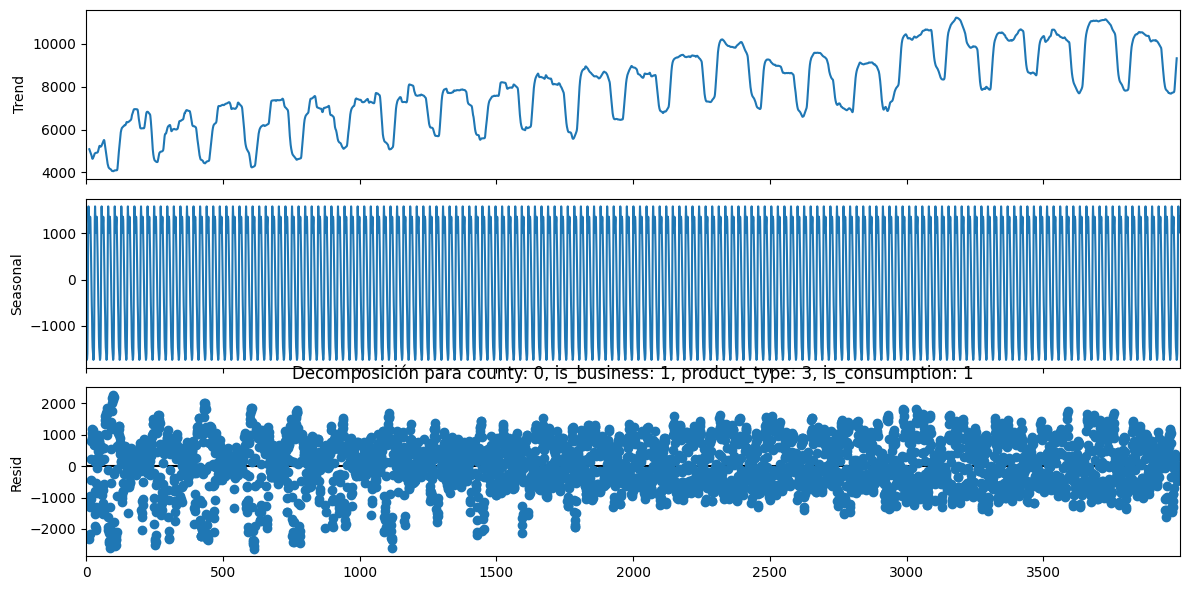

Guardado exitosamente en /imagenes/decomposition

Test de ADF para county: 0, is_business: 1, product_type: 3, is_consumption: 1

ADF Statistic: -9.9668, p-value: 0.0, conclusión: No hay raíz unitaria (Estacionario)
Entrenando modelo ARIMA para county: 0, is_business: 1, product_type: 3, is_consumption: 1

Generando combinaciones de hiperparámetros para county: 0, is_business: 1, product_type: 3, is_consumption: 1

No se aplica diferenciación ya que la serie es estacionaria

El número de modelos a probar es 32
Buscando mejor modelo para county: 0, is_business: 1, product_type: 3, is_consumption: 1

Probando un ARIMA(1, 0, 1)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(1, 1, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 0, 1)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 0)(24)
Probando un ARIMA(1, 0, 1)(2, 1, 1)(24)
Probando un ARIMA(1, 0, 2)(1, 0, 0)(24)
Probando un ARIMA(1, 0, 2)(1, 0, 1

In [14]:
resultados = save_results(data=data_model_capital, unique_combinations=unique_combinations, cols_to_group=cols_to_group, target='target')

In [15]:
resultados.to_excel('capital_resultados_arima.xlsx', index=False)